# Data 

In [0]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Hotel information are crawled from tripadvisor.ca for the town of Brockville. Although the website indicates that there are a total of 16 hotels in this town, a total of 39 hotels have been crawled, which means hotels from surrounding areas are also included in the dataset. There are a total of 3807 reviews included in the dataset, none of which is NaN in the 'reviewColumn'.

In [0]:
#Read in from pandas
hotelDf = pandas.read_csv('reviews.csv')
hotelDf.columns=['filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [0]:
hotelDf

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,data/ca/48320/556876/257741718.html,Stonefence Resort,"""We were in the area visiting a college and ch...",4,positive
1,data/ca/48320/556876/744885458.html,Stonefence Resort,"""The owners at the Stonefence Resort are aweso...",5,positive
2,data/ca/48320/556876/288026533.html,Stonefence Resort,"""This is a old beautiful property. Carpets we...",2,negative
3,data/ca/48320/556876/483137063.html,Stonefence Resort,"""My friends and I needed a room for the night ...",4,positive
4,data/ca/48320/556876/749763573.html,Stonefence Resort,"""My husband and I have been coming here for 10...",1,negative
...,...,...,...,...,...
3802,data/ca/1900745/14202769/693168652.html,Doran Bay Resort,"""This property has ten or so old cabins with s...",2,negative
3803,data/ca/1900745/14202769/623228554.html,Doran Bay Resort,"""We had stayed at this absolutely lovely, tran...",5,positive
3804,data/ca/1900745/14202769/633291025.html,Doran Bay Resort,"""The couple that runs the resort is wonderful....",5,positive
3805,data/ca/1900745/14202769/702293568.html,Doran Bay Resort,"""We stayed here after Toronto and on our way t...",4,positive


In [0]:
hotelDf['hotelName'].nunique()

39

In [0]:
hotelDf['reviewColumn'].isnull().sum()

0

In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            # using vader compound score (normalized between -1 and 1), which is a useful single unidimensional measure of sentiment analysis
            # -1 (most extreme negative) and +1 (most extreme positive)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [0]:
reviews = hotelDf['reviewColumn'].values

In [0]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 3807/3807 [00:04<00:00, 765.13it/s]


In [0]:
reviewDF.head()

,reviewCol,vader
0,"""We were in the area visiting a college and ch...",0.9799
1,"""The owners at the Stonefence Resort are aweso...",0.9634
2,"""This is a old beautiful property. Carpets we...",0.9663
3,"""My friends and I needed a room for the night ...",0.9862
4,"""My husband and I have been coming here for 10...",-0.9033


### Data Preprocessing
1. Find Topk words (No preprocessing steps now)
2. Reconstruct the above dataframe into CSV style..

In [0]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+') # using NLTK instead of regex
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in tokenize.regexp.regexp_tokenize(reviews[i], pattern='\w+')]) # using NLTK instead of regex
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
# top 500 frequent terms and df with 500 frequent terms as features
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=500)

In [0]:
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,room,clean,hotel,stay,breakfast,great,staff,rooms,would,nice,good,stayed,friendly,place,one,comfortable,night,well,area,pool,time,back,bed,desk,motel,location,like,inn,front,helpful,nthe,also,next,could,get,...,kitchen,season,items,double,others,change,vacation,machine,shopping,set,rates,waffles,canada,busy,courteous,rude,tea,toilet,fact,real,fast,less,swimming,poor,nicely,sausage,soon,closed,channel,dock,pay,saw,deal,housekeeping,ledge,unit,hair,returning,furniture,options
0,Stonefence Resort,4,positive,"""We were in the area visiting a college and ch...",0.9799,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Stonefence Resort,5,positive,"""The owners at the Stonefence Resort are aweso...",0.9634,0,0,0,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Stonefence Resort,2,negative,"""This is a old beautiful property. Carpets we...",0.9663,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Stonefence Resort,4,positive,"""My friends and I needed a room for the night ...",0.9862,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Stonefence Resort,1,negative,"""My husband and I have been coming here for 10...",-0.9033,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


# Q1. Sentiment Analysis and Aggregation

## (a) Compute average Vader sentiment and average ground truth rating per hotel.

In [0]:
AvgDF = finaldf[['hotelName','ratingScore','vader']].groupby('hotelName').mean()

In [0]:
AvgDF.head()

,ratingScore,vader
hotelName,,
1000 Islands B and B,4.923077,0.963985
48 King West,5.000000,0.959925
Best Inn Motel,4.033333,0.734373
Best Western Smiths Falls Hotel,4.150000,0.728495
Best Western University Inn,4.219298,0.796832


## (b) Rank hotels by

### (i) Average Ground Truth Sentiment

In [0]:
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Stonefence Resort', 'The Inn at Gran View', 'PJ&#39;s Motel',
       'Best Inn Motel', 'Econo Lodge', 'Best Western Smiths Falls Hotel',
       'Roger&#39;s Motel', 'Fairfield Inn &amp; Suites Canton',
       'Best Western University Inn',
       'Holiday Inn Express Canton - Potsdam', 'Bridgewaters Inn',
       'Capt.&#39;s Inn &amp; Suites', 'The Ship Motel',
       'Bridgeview Motel', 'Capt. Thomson&#39;s Resort',
       'Hill&#39;s Motor Court &amp; Marina Inn', 'Otter Creek Inn',
       'Rock Ledge Motel', 'Capricorn Motel Royale', 'Glen House Resort',
       'Country Squire Resort &amp; Spa',
       'Ramada by Wyndham Gananoque Provincial Inn',
       'Quality Inn &amp; Suites 1000 Islands', 'Travelodge Gananoque',
       'Holiday Inn Express &amp; Suites 1000 Islands - Gananoque',
       'Sir Isaac Brock B&amp;B Luxury Suites',
       'Tall Ships Landing Coastal Resort',
       'Holiday Inn Express Hotel &amp; Suites Brockville',
       'Pine Street Inn B&amp;B', 'The No

In [0]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [0]:
# top 5 hotel based on ground truth ratings
hotelRatingDfGt = getHotelRank(finaldf)
hotelRatingDfGt.head()

,hotelName,avgRatingScore
32,48 King West,5.000000
25,Sir Isaac Brock B&amp;B Luxury Suites,4.971429
34,Green Door Bed and Breakfast,4.937500
36,1000 Islands B and B,4.923077
13,Bridgeview Motel,4.919355


In [0]:
# bottom 5 hotel based on ground truth ratings
hotelRatingDfGt.tail(5)

,hotelName,avgRatingScore
37,Travelodge Brockville,3.339130
21,Ramada by Wyndham Gananoque Provincial Inn,3.335404
35,Days Inn by Wyndham Brockville,3.323887
2,PJ&#39;s Motel,3.300000
4,Econo Lodge,3.142857


### (ii) Average Vader Compound Sentiment Score

In [0]:
# top 5 hotel based on vader compound score
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')
hotelRatingDfVd.head()

,hotelName,avgRatingScore
36,1000 Islands B and B,0.963985
32,48 King West,0.959925
34,Green Door Bed and Breakfast,0.957954
25,Sir Isaac Brock B&amp;B Luxury Suites,0.952831
7,Fairfield Inn &amp; Suites Canton,0.952640


In [0]:
# bottom 5 hotel based on vader compound score
hotelRatingDfVd.tail(5)

,hotelName,avgRatingScore
4,Econo Lodge,0.542501
22,Quality Inn &amp; Suites 1000 Islands,0.522605
38,Doran Bay Resort,0.480460
37,Travelodge Brockville,0.449901
2,PJ&#39;s Motel,0.248600


### Show both top-5 and bottom-5 for both ranking methods. Do they agree or are there inter- esting differences?

- 4 out of 5 hotels in the top 5 are shared by both measures, though their rankings are slightly different. Considering that the scores of top 5 hotels both in terms of true and vader scores are very similar, it can be said that both measures produce similar top 5 results. 

- 3 out of 5 hotels in the bottom 5 hotels are shared by both measures, with large variances in rankings. Interestingly, the lowest score (0.24 for 'PJ&#39;s Motel') is  much lower than the second lowest score (0.45 for 'Travelodge Brockville') in terms of vader sentiment. However, in terms of ground truth, all bottom 5 hotels share similar scores. Also note that all vader compount scores are greater than zero, indicating that the bottom 5 hotels are seen as more neutral than bad.

# Q2. Frequency Analysis

## (a) Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection. Do you note anything interesting and/or locale-specific about these top-ranked words?

In [0]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('brockville')
    stop.add('motel')
    stop.add('inn')

    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+')
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [0]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')

In [0]:
topkGroundPos

[('clean', 1816),
 ('great', 1433),
 ('breakfast', 1281),
 ('nice', 1078),
 ('good', 960),
 ('friendly', 939),
 ('would', 921),
 ('stayed', 887),
 ('comfortable', 879),
 ('place', 792),
 ('well', 758),
 ('area', 702),
 ('one', 652),
 ('time', 590),
 ('night', 583),
 ('pool', 580),
 ('helpful', 531),
 ('back', 509),
 ('location', 507),
 ('also', 442),
 ('recommend', 439),
 ('bed', 431),
 ('right', 417),
 ('like', 388),
 ('nthe', 385),
 ('quiet', 382),
 ('next', 382),
 ('view', 368),
 ('definitely', 366),
 ('best', 365),
 ('two', 360),
 ('everything', 358),
 ('really', 352),
 ('restaurant', 344),
 ('close', 342),
 ('desk', 341),
 ('town', 341),
 ('beds', 340),
 ('enjoyed', 339),
 ('bay', 334),
 ('front', 327),
 ('excellent', 325),
 ('small', 324),
 ('could', 314),
 ('get', 313),
 ('wonderful', 310),
 ('owners', 308),
 ('price', 306),
 ('family', 303),
 ('service', 302)]

In [0]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')
topkGroundNeg

[('breakfast', 532),
 ('would', 522),
 ('clean', 492),
 ('one', 457),
 ('night', 407),
 ('good', 392),
 ('nice', 337),
 ('desk', 331),
 ('place', 320),
 ('front', 299),
 ('bed', 295),
 ('stayed', 286),
 ('bathroom', 269),
 ('get', 262),
 ('could', 261),
 ('like', 256),
 ('nthe', 235),
 ('back', 228),
 ('door', 228),
 ('next', 224),
 ('pool', 219),
 ('time', 206),
 ('small', 200),
 ('even', 198),
 ('area', 190),
 ('great', 189),
 ('well', 187),
 ('friendly', 185),
 ('price', 182),
 ('told', 179),
 ('old', 177),
 ('also', 175),
 ('went', 169),
 ('floor', 163),
 ('check', 162),
 ('first', 160),
 ('two', 155),
 ('beds', 155),
 ('day', 155),
 ('got', 154),
 ('said', 153),
 ('people', 152),
 ('location', 152),
 ('comfortable', 150),
 ('little', 148),
 ('morning', 142),
 ('never', 141),
 ('booked', 140),
 ('way', 139),
 ('shower', 136)]

The two lists of most common words from positive and negative reviews share many words such as 'nights' and 'breakfast'. These words can be disregarded since they provide more information on the use-frequency of the word than whether the word is indicative of a sentiment. Positive words such as 'nice' and 'good' are in the negative word list, and vice versa, for similar reasons.  



## (b) Repeat this analysis for the top-50 noun phrases and note any interesting results.

In [0]:
tagger = PerceptronTagger()
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [0]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [0]:
# Noun Phrase Extraction Support Functions
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
# a leaf contains a noun phrase as defined above
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent noun phrases
    counter = Counter()
    for review in reviews:
        counter.update(flatten([word
                        for word 
                        # finding all noun phrases in review excluding punctuations
                        in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the noun phrase from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
# k most frequent noun phrasing including both positive and negative gound truth
topk_NP, finaldf_NP = newDataFrameTransformation(hotelDf, reviewDF)

In [0]:
#reviewDF.head()
finaldf_NP.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,front desk,alexandria bay,boldt castl,great place,otter creek inn,st lawrenc river,green door,outdoor pool,comfort inn,continent breakfast,hot tub,next morn,great locat,breakfast room,alex bay,holiday inn,next day,good valu,boat tour,free breakfast,first time,holiday inn express,coffe maker,next year,smith fall,nthe room,clean room,next time,great stay,park lot,comfort bed,front desk staff,friendli staff,main street,glen hous,...,good bed,nice locat,super comfi,great convers,recept desk,standard room,ramada inn,island cruis,wood floor,fit centr,quebec citi,coupl day,min drive,internet connect,sir isaac,host ida,stone fenc,full breakfast,ok noth,excel view,canadian side,updat room,offic staff,separ bedroom,qualiti inn gran view,wide varieti,extra night,littl pricey,basic hotel,decent breakfast,key card,expens room,breakfast item,nthe servic,tv work,site restaur,free hot breakfast,friday night,hour drive,bedroom suit
0,Stonefence Resort,4,positive,"""We were in the area visiting a college and ch...",0.9799,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Stonefence Resort,5,positive,"""The owners at the Stonefence Resort are aweso...",0.9634,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Stonefence Resort,2,negative,"""This is a old beautiful property. Carpets we...",0.9663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Stonefence Resort,4,positive,"""My friends and I needed a room for the night ...",0.9862,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Stonefence Resort,1,negative,"""My husband and I have been coming here for 10...",-0.9033,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# get top k noun-phrases 
def getTopK_phrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    # stop words have already been filtered in acceptable_word
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))
    topk = counter.most_common(k)
    return topk

In [0]:
NPAnalysisDf = finaldf_NP[['reviewCol','groundTruth','vader']]

In [0]:
topkGroundPos_NP = getTopK_phrase(df=NPAnalysisDf, k=50, label_value='positive')
topkGroundPos_NP

[('front desk', 118),
 ('alexandria bay', 103),
 ('boldt castl', 90),
 ('great place', 86),
 ('otter creek inn', 72),
 ('green door', 68),
 ('st lawrenc river', 62),
 ('outdoor pool', 51),
 ('great locat', 51),
 ('alex bay', 49),
 ('next year', 47),
 ('hot tub', 46),
 ('holiday inn', 45),
 ('continent breakfast', 44),
 ('great stay', 44),
 ('boat tour', 44),
 ('comfort inn', 42),
 ('first time', 42),
 ('smith fall', 39),
 ('clean room', 38),
 ('short walk', 38),
 ('st lawrenc', 36),
 ('good valu', 36),
 ('comfort bed', 34),
 ('next time', 34),
 ('breakfast room', 34),
 ('main street', 34),
 ('friendli staff', 33),
 ('holiday inn express', 33),
 ('next morn', 32),
 ('coffe maker', 31),
 ('indoor pool', 31),
 ('sir isaac brock', 31),
 ('nice place', 30),
 ('front desk staff', 30),
 ('free breakfast', 29),
 ('rock ledg', 29),
 ('rock ledg motel', 29),
 ('glen hous', 29),
 ('nthe room', 28),
 ('night stay', 28),
 ('clean staff', 28),
 ('great view', 27),
 ('reason price', 27),
 ('great tim

In [0]:
topkGroundNeg_NP = getTopK_phrase(df=NPAnalysisDf, k=50, label_value='negative')
topkGroundNeg_NP

[('front desk', 156),
 ('next day', 32),
 ('next morn', 27),
 ('free breakfast', 25),
 ('comfort inn', 24),
 ('park lot', 24),
 ('breakfast room', 23),
 ('custom servic', 20),
 ('continent breakfast', 20),
 ('good valu', 20),
 ('next door', 20),
 ('holiday inn express', 20),
 ('doubl bed', 19),
 ('coffe maker', 19),
 ('best western', 19),
 ('nthe room', 19),
 ('alexandria bay', 17),
 ('boldt castl', 17),
 ('outdoor pool', 17),
 ('air condition', 16),
 ('mini fridg', 15),
 ('hot breakfast', 15),
 ('hot water', 14),
 ('first floor', 14),
 ('second floor', 14),
 ('hot tub', 14),
 ('good thing', 13),
 ('queen bed', 13),
 ('night stay', 13),
 ('first room', 13),
 ('glen hous', 13),
 ('staff member', 13),
 ('front desk staff', 12),
 ('first time', 12),
 ('boat tour', 12),
 ('holiday inn', 12),
 ('day inn', 12),
 ('qualiti inn', 11),
 ('next time', 11),
 ('great place', 11),
 ('credit card', 11),
 ('smith fall', 10),
 ('tim horton', 10),
 ('indoor pool', 10),
 ('first night', 10),
 ('bathroom

Word frequencies in the positive noun phrase list is generally much higher than that of the neigative noun phrase list. There are still phrases that exist in both lists, though a lot less than part a). 

Also, the positive NP list is much more consistent than the negative as well as in part a). 

# Q3. Mutual Information

## (a) Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment- bearing non-stopwords in the review collection. Do you note anything interesting and/or locale-specific about these top-ranked words?

In [0]:
# get Top K mutual information terms from the dataframe
# 0 (no mutual information) and 1 (perfect correlation)
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
      # computes mutual information between ground truth(pos/neg) and the word of interest
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
# most sentiment-bearing terms from top k words including both positive and negative 
miScoredf = getMI(topk, finaldf)
miScoredf.head(50)

,Word,MI Score
256,dirty,0.029281
5,great,0.026771
138,told,0.019080
154,said,0.017258
274,smell,0.015518
0,room,0.014626
15,comfortable,0.014155
39,bathroom,0.014084
475,rude,0.013815
296,paid,0.013788


MI of most frequent words is more informative than pos/neg categorization of the same list of words. Many words are clearly distinguishable based on positive/negative sentiment, though not labeled. 

## (b) Repeat this analysis for the top-50 noun phrases and note any interesting results.

In [0]:
# get Top K mutual information terms from the dataframe
def getMI_NP(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf_NP[label_column], finaldf_NP[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Noun Phrase','MI Score']
    return miScoredf

In [0]:
# most sentiment-bearing terms from top k NP including both positive and negative 
miScored_NP = getMI_NP(topk_NP, finaldf_NP)
miScored_NP.head(50)

,Noun Phrase,MI Score
0,front desk,0.008622
28,great stay,0.003641
23,next year,0.002962
16,next day,0.002709
6,green door,0.002645
207,bathroom floor,0.002613
51,sir isaac brock,0.002365
70,air condition,0.002117
127,first room,0.002064
369,hot food,0.002044


Similar to MI of words, the MI of noun phrases are fairly informative. The NP 'front desk' has a much higher MI than the rest, indicating that it carries a lot of sentimental value. This might be because the phrase 'front desk' reflects the main aspect of customer service in a hotel, and thus can greatly impact the experience of a customer's stay. 

# Q4. Pointwise Mutual Information

## (a) For ground truth sentiment, calculate the top-50 words according to PMI of the word occuring with (i) positive reviews and (ii) negative reviews. Do you note anything interesting and/or locale-specific about these top-ranked words?

In [0]:
# Simple example of getting pairwise mutual information of a term
# Analyzing PMI for every word for all reviews no matter if the review contains the word or not
# Normalized PMI range: -1 for never occurring together, 0 for independence, and +1 for complete co-occurrence
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]: # 1 for word in df, 0 for not
            px = sum(df['groundTruth']==i)/len(df) #individual sentiment probability
            py = sum(df[x]==j)/len(df) # individual word probability 
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df) #joint probability (probability of sent x and word y in/not in the same review)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py+0.0001)) #smoothing
            else:
                pmi = math.log(pxy/(px*py)) # pmi=0 if x and y are independent
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
# calculates PMI of word IN review for either pos and neg sentiments
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py+0.0001))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [0]:
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [0]:
# positive/negative pmi lists for most frequent words in final df, and pmi df 
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████| 500/500 [00:17<00:00, 27.98it/s]


In [0]:
# sorted frequent words in positive reviews based on pmi value
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
329,ida,0.320163
393,david,0.320163
186,hosts,0.314228
137,perfect,0.286096
411,spotless,0.285477
152,highly,0.284169
293,delicious,0.277962
357,thanks,0.264900
402,recommended,0.260264
494,ledge,0.256984


In [0]:
# sorted frequent words in negative reviews based on pmi value
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
475,rude,1.217779
256,dirty,1.205395
483,poor,1.045525
274,smell,1.038020
296,paid,1.000749
442,walls,0.993265
477,toilet,0.989359
457,loud,0.987256
138,told,0.982801
435,cleaned,0.972657


As seen in the two lists above, the top ranked words in both the positive and negative lists are very informative. Interestingly, many top words in the positive list are related to owners, such as 'david', 'host', 'owner', which suggests that many customers have experienced positive interactions through the host of the hotel. 

## (b) Repeat this analysis for the top-50 noun phrases and note any interesting results.

In [0]:
pmiposlist_NP, pmineglist_NP, pmidf_NP = pmiForAllCal(finaldf_NP, topk = topk_NP)

100%|██████████| 500/500 [00:13<00:00, 38.04it/s]


In [0]:
# sorted frequent noun phrases in positive reviews based on pmi value
pmiposlist_NP.sort_values('pmi',ascending=0).head(50)

,word,pmi
416,top notch,0.320163
180,privat balconi,0.320163
362,jame street,0.320163
190,wonder host,0.320163
28,great stay,0.320163
323,first stay,0.320163
475,host ida,0.320163
437,entir place,0.320163
383,nice select,0.320163
182,great spot,0.320163


In [0]:
# sorted frequent noun phrases in negative reviews based on pmi value
pmineglist_NP.sort_values('pmi',ascending=0).head(50)

,word,pmi
431,previou guest,1.294740
355,small room,1.294740
458,dire need,1.294740
369,hot food,1.294740
207,bathroom floor,1.199430
219,toilet paper,1.176957
392,ear plug,1.112419
399,hotel manag,1.112419
420,plu side,1.112419
455,second room,1.112419


Analysis of the PMI of noun phrases are also very informative, with the noun phrases in the negative list reflecting many aspects of a hotel stay, such as room size, food, sanitation, and ventilation. 

## (c) Repeat this analysis for the single top and single bottom hotel (according to the ground truth rating). Do you gain any useful hotel-specific insights about what is good and bad about these two hotels? If not, explain why not.

In [0]:
# finding subset of hotelDF that only includes the top/bot hotel
hotelDf_top = hotelDf[hotelDf['hotelName']=='Bridgeview Motel']
hotelDf_bot = hotelDf[hotelDf['hotelName']=='PJ&#39;s Motel']

In [0]:
# only including reviews of the top/bot hotel and compound vader scores
reviewDF_top = reviewDF.iloc[hotelDf_top.index]
reviewDF_bot = reviewDF.iloc[hotelDf_bot.index]

hotelDf_top.reset_index(inplace=True)
hotelDf_bot.reset_index(inplace=True)
reviewDF_top.reset_index(inplace=True)
reviewDF_bot.reset_index(inplace=True)

In [0]:
# transforming top/bot hotel reviews into noun phrase features and getting top k np
topk_top_NP, finaldf_top_NP = newDataFrameTransformation(hotelDf_top, reviewDF_top)
topk_bot_NP, finaldf_bot_NP = newDataFrameTransformation(hotelDf_bot, reviewDF_bot)

In [0]:
pmiposlist_top_NP, pmineglist_top_NP, pmidf_top_NP = pmiForAllCal(finaldf_top_NP, topk=topk_top_NP)
pmiposlist_bot_NP, pmineglist_bot_NP, pmidf_bot_NP = pmiForAllCal(finaldf_bot_NP, topk=topk_bot_NP)

100%|██████████| 64/64 [00:00<00:00, 82.20it/s]


In [0]:
pmiposlist_top_NP.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,bridgeview motel,0.016261
208,morn coffe,0.016261
215,alexandria bay conveni locat,0.016261
214,day michel,0.016261
213,wonder experi,0.016261
212,great stay,0.016261
211,nice size flat screen tv,0.016261
210,nice size,0.016261
209,perfect spot,0.016261
207,good care,0.016261


In [0]:
pmineglist_bot_NP.sort_values('pmi',ascending=0).head(50)

,word,pmi
63,similar review wait staff,0.693147
30,nice price,0.693147
28,usual peopl,0.693147
27,room suit everyth,0.693147
26,brother sister,0.693147
25,secret place north,0.693147
1,bike weekend,0.693147
38,huge yellow stain,0.693147
39,coupl sheet,0.693147
40,toilet paper,0.693147


In [0]:
# number of reviews for top and bot hotels
hotelDf_top.shape, hotelDf_bot.shape

((62, 6), (10, 6))

Looking at the positive noun phrases for the top hotel, all of which are around zero, which means the phrases are independent of the positive sentiment values. 

The bottom hotel shows a list of negative phrases with PMIs from 0.69 to -6.22. Interestingly, the phrases with negative PMI have a lot of positive phrases (as it should) such as 'awesome host' and 'cant wait', meaning that their PMI are quite informative. 

# Q5. General Plots

## **(a) Histogram**

### (a) Show separate histograms of ground truth and Vader sentiment scores (ignore hotel ID). Do you notice any interesting differences?

In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5]
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='x')
        plt.hist(y, bins, label='y')
        plt.legend(loc='upper right')
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf()

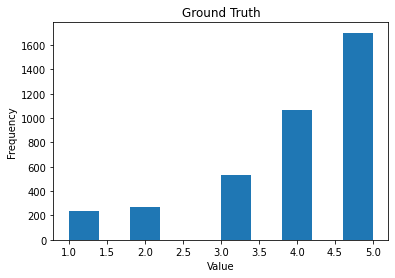

In [0]:
getHistogram('ratingScore', 'Ground Truth')

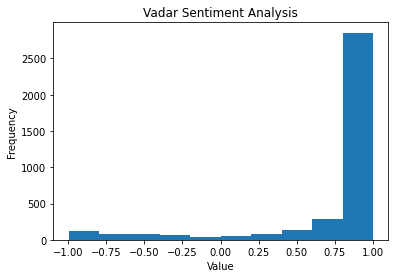

In [0]:
getHistogram('vader', 'Vadar Sentiment Analysis')

Both plots show an overwhelming amount of 5-star (or vader=1) reviews, with vader analysis having a higher frequency (>2500 compared to >1600). Also, ground truth shows no neutral reviews (i.e. 2.5 stars) because the code only assigns positive (>=3) and negative (<=2) sentiments. Whereas vader sentiment analysis is able to show neutral reviews, though they only account for a small portion of the overall number of reviews. 

### (b) Show a histogram of the number of reviews per hotel. Do you notice any interesting trends? Are these expected?

In [0]:
def reviews_num(dataframe):
    plt.figure()
    dataframe[['reviewCol']].groupby(finaldf['hotelName']).agg(['count']).plot(kind='bar',figsize=[20,8],legend=None)

<Figure size 432x288 with 0 Axes>

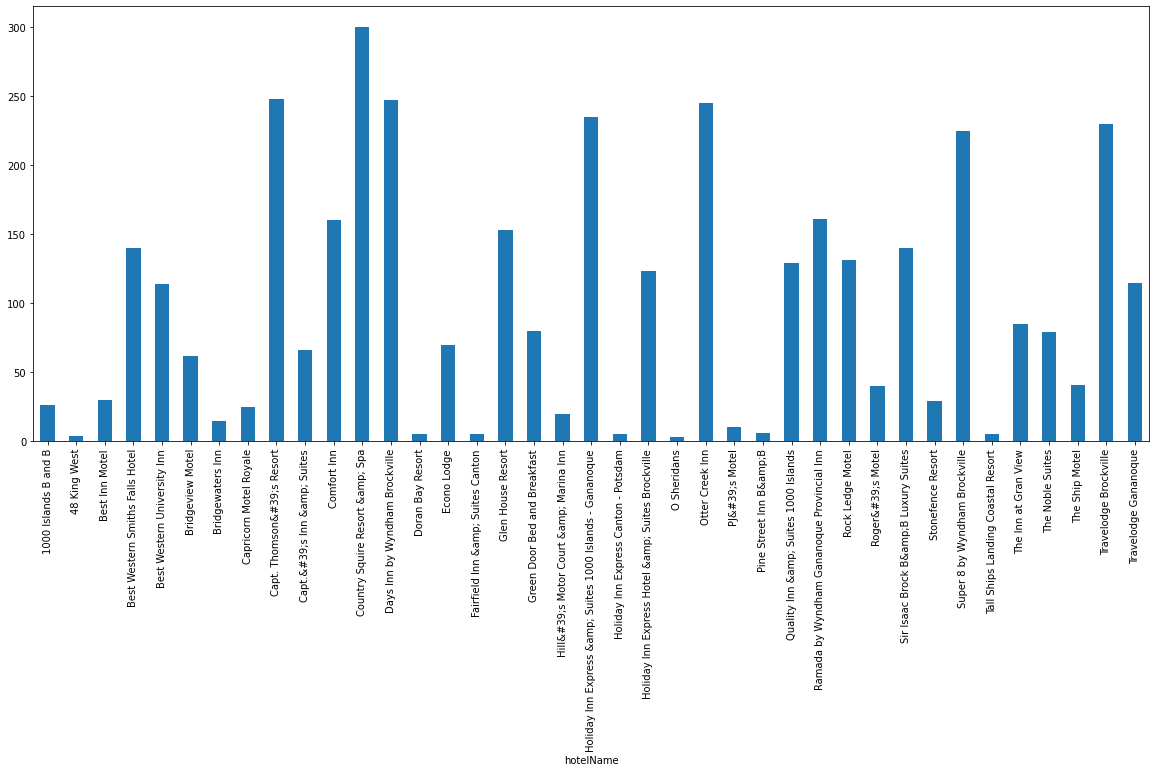

In [0]:
reviews_num(finaldf)

The number of reviews amongst hotels vary greatly, ranging from roughly 10 to over 300 reviews per hotel. Notably, the hotels with the most numbers of reviews are not seen in either the top or bottom 5 hotels. This suggests that the more a hotel is reviewed, the less likely that the hotel will be categorized in either extremes (very good or very bad). 

## **(b) Boxplots**

### (a) In two plots, one for ground truth star rating and one for Vader sentiment, show a plot of 5 side-by-side boxplots of these scores.

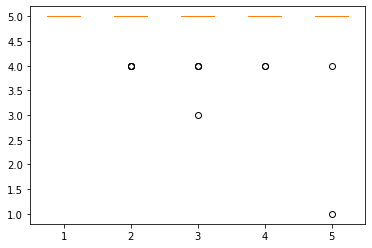

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

king_west = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
sir_isaac = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
green_door = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
islands = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
bridgeview = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [king_west, sir_isaac, green_door, islands, bridgeview]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

The median values for all top 5 hotels are 5 stars. This is because every one of the top 5 hotels have an overwhelming amount of 5 stars compared to lower stars, which are shown as outliers in the box plot. This is also caused by insufficient number of reviews for the top 5 hotels. 

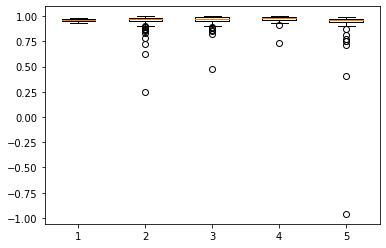

In [0]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

king_west = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['vader']
sir_isaac = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['vader']
green_door = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['vader']
islands = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['vader']
bridgeview = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['vader']

data_vader = [king_west, sir_isaac, green_door, islands, bridgeview]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data_vader)
plt.show()

Simliar to the box plot for ground truth ratings, the vader plot shows a median value at around 1, for similar reasons. 

### (b) Report the mean and variance of the ground truth and Vader sentiment scores for the top-5 ranked hotels according to star rating.

In [0]:
def mvcal(data):
    values =[]
    for review in data:
        values.append([review.mean(),review.var()])
    values_df = pandas.DataFrame(values)
    values_df.columns = ['mean','variance']
    return values_df

In [0]:
#Ground Truth
gt_stats_df = mvcal(data)
gt_stats_df

,mean,variance
0,5.000000,0.000000
1,4.971429,0.027955
2,4.937500,0.084652
3,4.923077,0.073846
4,4.919355,0.272078


In [0]:
#Vader
vd_stats_df = mvcal(data_vader)
vd_stats_df

,mean,variance
0,0.959925,0.000586
1,0.952831,0.006010
2,0.957954,0.004310
3,0.963985,0.002586
4,0.902356,0.066055


For both GT and Vader, the means are nearly 5 for GT and 1 for Vader, with minimal variances.

### (c) Which do you find more informative, the boxplots or the mean and variance, or are they equally informative? Why?

In this case, the mean and variance provide more information than the box plot since the data points are very clustered towards 5-stars/1 vader score and is difficult to visualize. 

## **(c) Scatterplots and heatmaps**

### (a) Show both a scatterplot and heatmap of ground truth score (star rating) versus Vader sentiment score. Each review is a point on the scatterplot. Do you notice anything interesting? What does this tell you about star ratings vs. Vader sentiment scores? What does this tell you about human ratings and/or Vader sentiment analysis?

Text(0.5, 0, 'Vader Score')

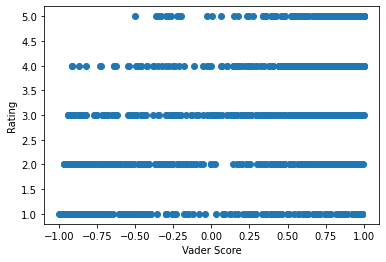

In [0]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

In [0]:
from scipy.stats.kde import gaussian_kde

In [0]:
def heatmap(x, y, x_label='Vader Score', y_label='Rating'):

    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
    ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

    ax1.set_xlim(x.min(), x.max())
    ax1.set_ylim(y.min(), y.max())
    ax2.set_xlim(x.min(), x.max())
    ax2.set_ylim(y.min(), y.max())


    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

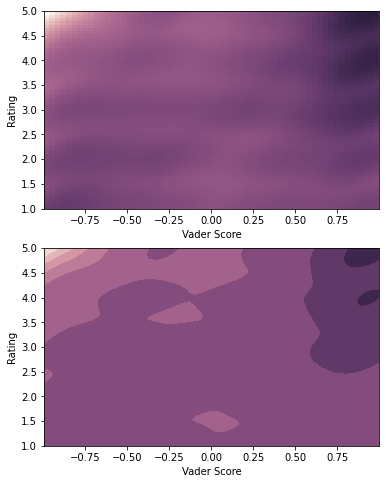

In [0]:
heatmap(x,y)

- Both the scatter plot and heat maps show a higher clustering of reviews towards rating=5 and vader=1. This indicates that the the two metrics agree more towards higher scores, but also there are more reviews with higher scores. 

- Note the elongated dark purple area in the top right corner of the heatmap, this suggests that there is a large number of GT ratings between 3 and 5 stars that are seen as extremely positive by the vader analysis. This means that the vader analysis tends to assign more extreme positives than ground truth, which is also reflected in the histograms in part a). 

- Considering human-vs-vader, this means that the vader algorithm can't distinguish reviews that are more sentimentally neutral. 

### (b) Show two scatterplots and two heatmaps of the length of reviews versus each of ground truth score and Vader sentiment score. Each review is a point on the scatterplot. Are there any trends?

In [0]:
# length based on number of words
review_len = np.array([len(x.split()) for x in finaldf['reviewCol']])

Text(0.5, 0, 'Length')

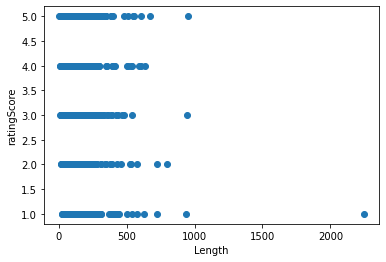

In [0]:
# scatter plot for review length vs ground truth ratings
plt.plot(review_len, y, 'o')
plt.ylabel('ratingScore')
plt.xlabel('Length')

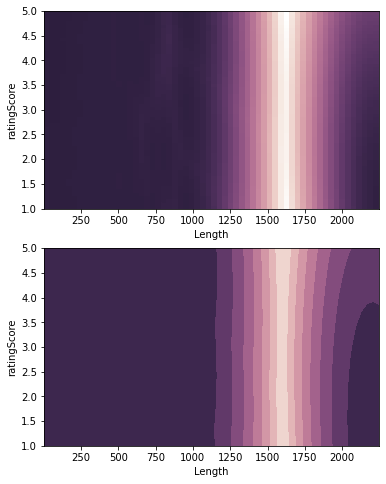

In [0]:
# heat map for review length vs ground truth ratings
heatmap(review_len, y, x_label='Length',y_label='ratingScore')

Text(0.5, 0, 'Length')

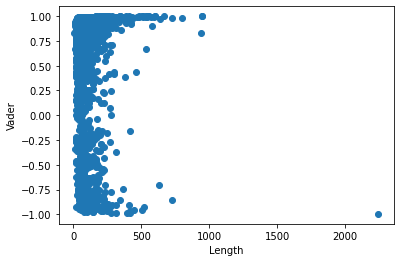

In [0]:
# scatter plot for review length vs vader scores
plt.plot(review_len, x, 'o')
plt.ylabel('Vader')
plt.xlabel('Length')

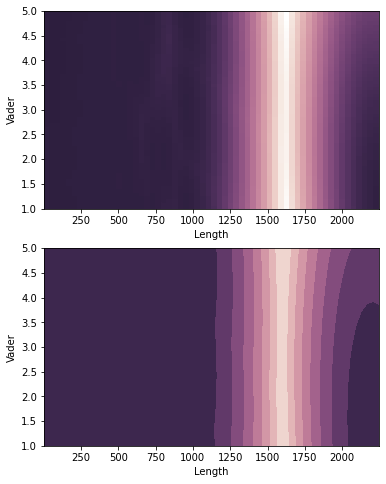

In [0]:
# heat map for review length vs vader scores
heatmap(review_len, y, x_label='Length',y_label='Vader')

The majority of lengths of reviews are less than 500 words. From the scatter plots, especially the vader plot. it can be seen that the most positive and negative reviews have relatively higher length of reviews than the more neutral reviews. 

### (c) Show two scatterplots of the number of reviews per hotel versus each of average ground truth score and average Vader sentiment score. In this case, each hotel is a single point on the scatterplot. Are there any trends?

In [0]:
review_count = finaldf.hotelName.value_counts()
review_count

Country Squire Resort &amp; Spa                              300
Capt. Thomson&#39;s Resort                                   248
Days Inn by Wyndham Brockville                               247
Otter Creek Inn                                              245
Holiday Inn Express &amp; Suites 1000 Islands - Gananoque    235
Travelodge Brockville                                        230
Super 8 by Wyndham Brockville                                225
Ramada by Wyndham Gananoque Provincial Inn                   161
Comfort Inn                                                  160
Glen House Resort                                            153
Best Western Smiths Falls Hotel                              140
Sir Isaac Brock B&amp;B Luxury Suites                        140
Rock Ledge Motel                                             131
Quality Inn &amp; Suites 1000 Islands                        129
Holiday Inn Express Hotel &amp; Suites Brockville            123
Travelodge Gananoque     

In [0]:
# number of reviews per hotel for every hotel
num_reviews = np.array([review_count[hotelNames[x]] for x in range(len(hotelNames))])


itemAnalysisDf = finaldf[['hotelName','groundTruth','ratingScore','vader']]

# df with hotel name and corresponding vader/ground truth scores (averaged)
hotelAnalysisDf = itemAnalysisDf.groupby('hotelName', as_index=True).mean()
gt_score = np.array([hotelAnalysisDf.loc[hotelNames[x]]['ratingScore'] for x in range(len(hotelNames))])
vd_score = np.array([hotelAnalysisDf.loc[hotelNames[x]]['vader'] for x in range(len(hotelNames))])

Text(0.5, 0, 'Number of Reviews')

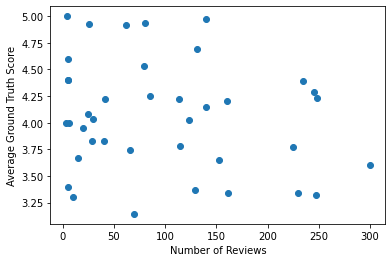

In [0]:
# scatter plot for number of reviews vs average hotel ground truth
plt.plot(num_reviews, gt_score, 'o')
plt.ylabel('Average Ground Truth Score')
plt.xlabel('Number of Reviews')

Text(0.5, 0, 'Number of Reviews')

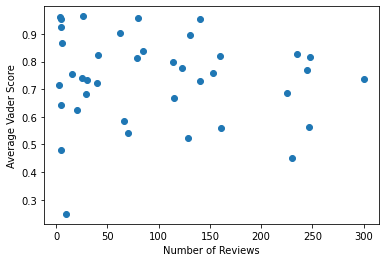

In [0]:
# scatter plot for number of reviews vs average hotel vader score
plt.plot(num_reviews, vd_score, 'o')
plt.ylabel('Average Vader Score')
plt.xlabel('Number of Reviews')

From the scatter plots above, a clear trend is difficult to distinguish, but based on the vader plot, it appears many hotels with less number of reviews have a higher rating.